## Introduction

The purpose of this notebook is to assess educational inequality through analysing socioeconomic factors and school performance, in terms of ACT scores

# The Data

The 2016 dataset containing SAT/ACT scores and socioeconomic characteristics for school districts comes from EdGap.org. EdGap Data Source: https://www.edgap.org/#4/37.89/-97.00

Dataset providing basic information about each school, pulled from the National Center for Education Statistics.

NCES Data Source: https://nces.ed.gov/ccd/pubschuniv.asp

NCES Dataset: https://www.dropbox.com/s/lkl5nvcdmwyoban/ccd_sch_029_1617_w_1a_11212017.csv?dl=0

The notebook with the data preparation can be found here in this repo: https://github.com/pintoanabel/Education-Inequality/blob/main/Pinto_Prep_DATA_3320_Education_Inequality_Data_Preparation.ipynb

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

from sklearn.linear_model import LinearRegression

from mpl_toolkits.mplot3d import Axes3D

import statsmodels.formula.api as smf
from mpl_toolkits import mplot3d
from matplotlib import cm

from sklearn import linear_model, tree
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.anova import anova_lm

import plotly.offline as pyo
import plotly.graph_objs as go

from itertools import combinations
from math import comb

from os import name

## Load clean data

##### $\rightarrow$ Load the clean data set from Github. 

In [ ]:
df_train = pd.read_csv('https://raw.githubusercontent.com/pintoanabel/Education-Inequality/main/clean_education_inequality%20(3).csv')

##### $\rightarrow$ Review the contents of the data set.

## State your questions

The overall problem is to determine whether and how average school ACT performance is related to socioeconomic factors. To answer this general problem, you will need to ask specific questions about the data.


##### $\rightarrow$ List your questions about the data that will help you solve the problem.

- is median income a significant predictor of ACT scores?
- what is the best predictor of ACT scores?
- does household size affect ACT scores?
- what is the best model to predict ACT scores?

# Analysis

## Pairplot for all Variables

Plot out all potential relationships between the variables using sns.pairplot

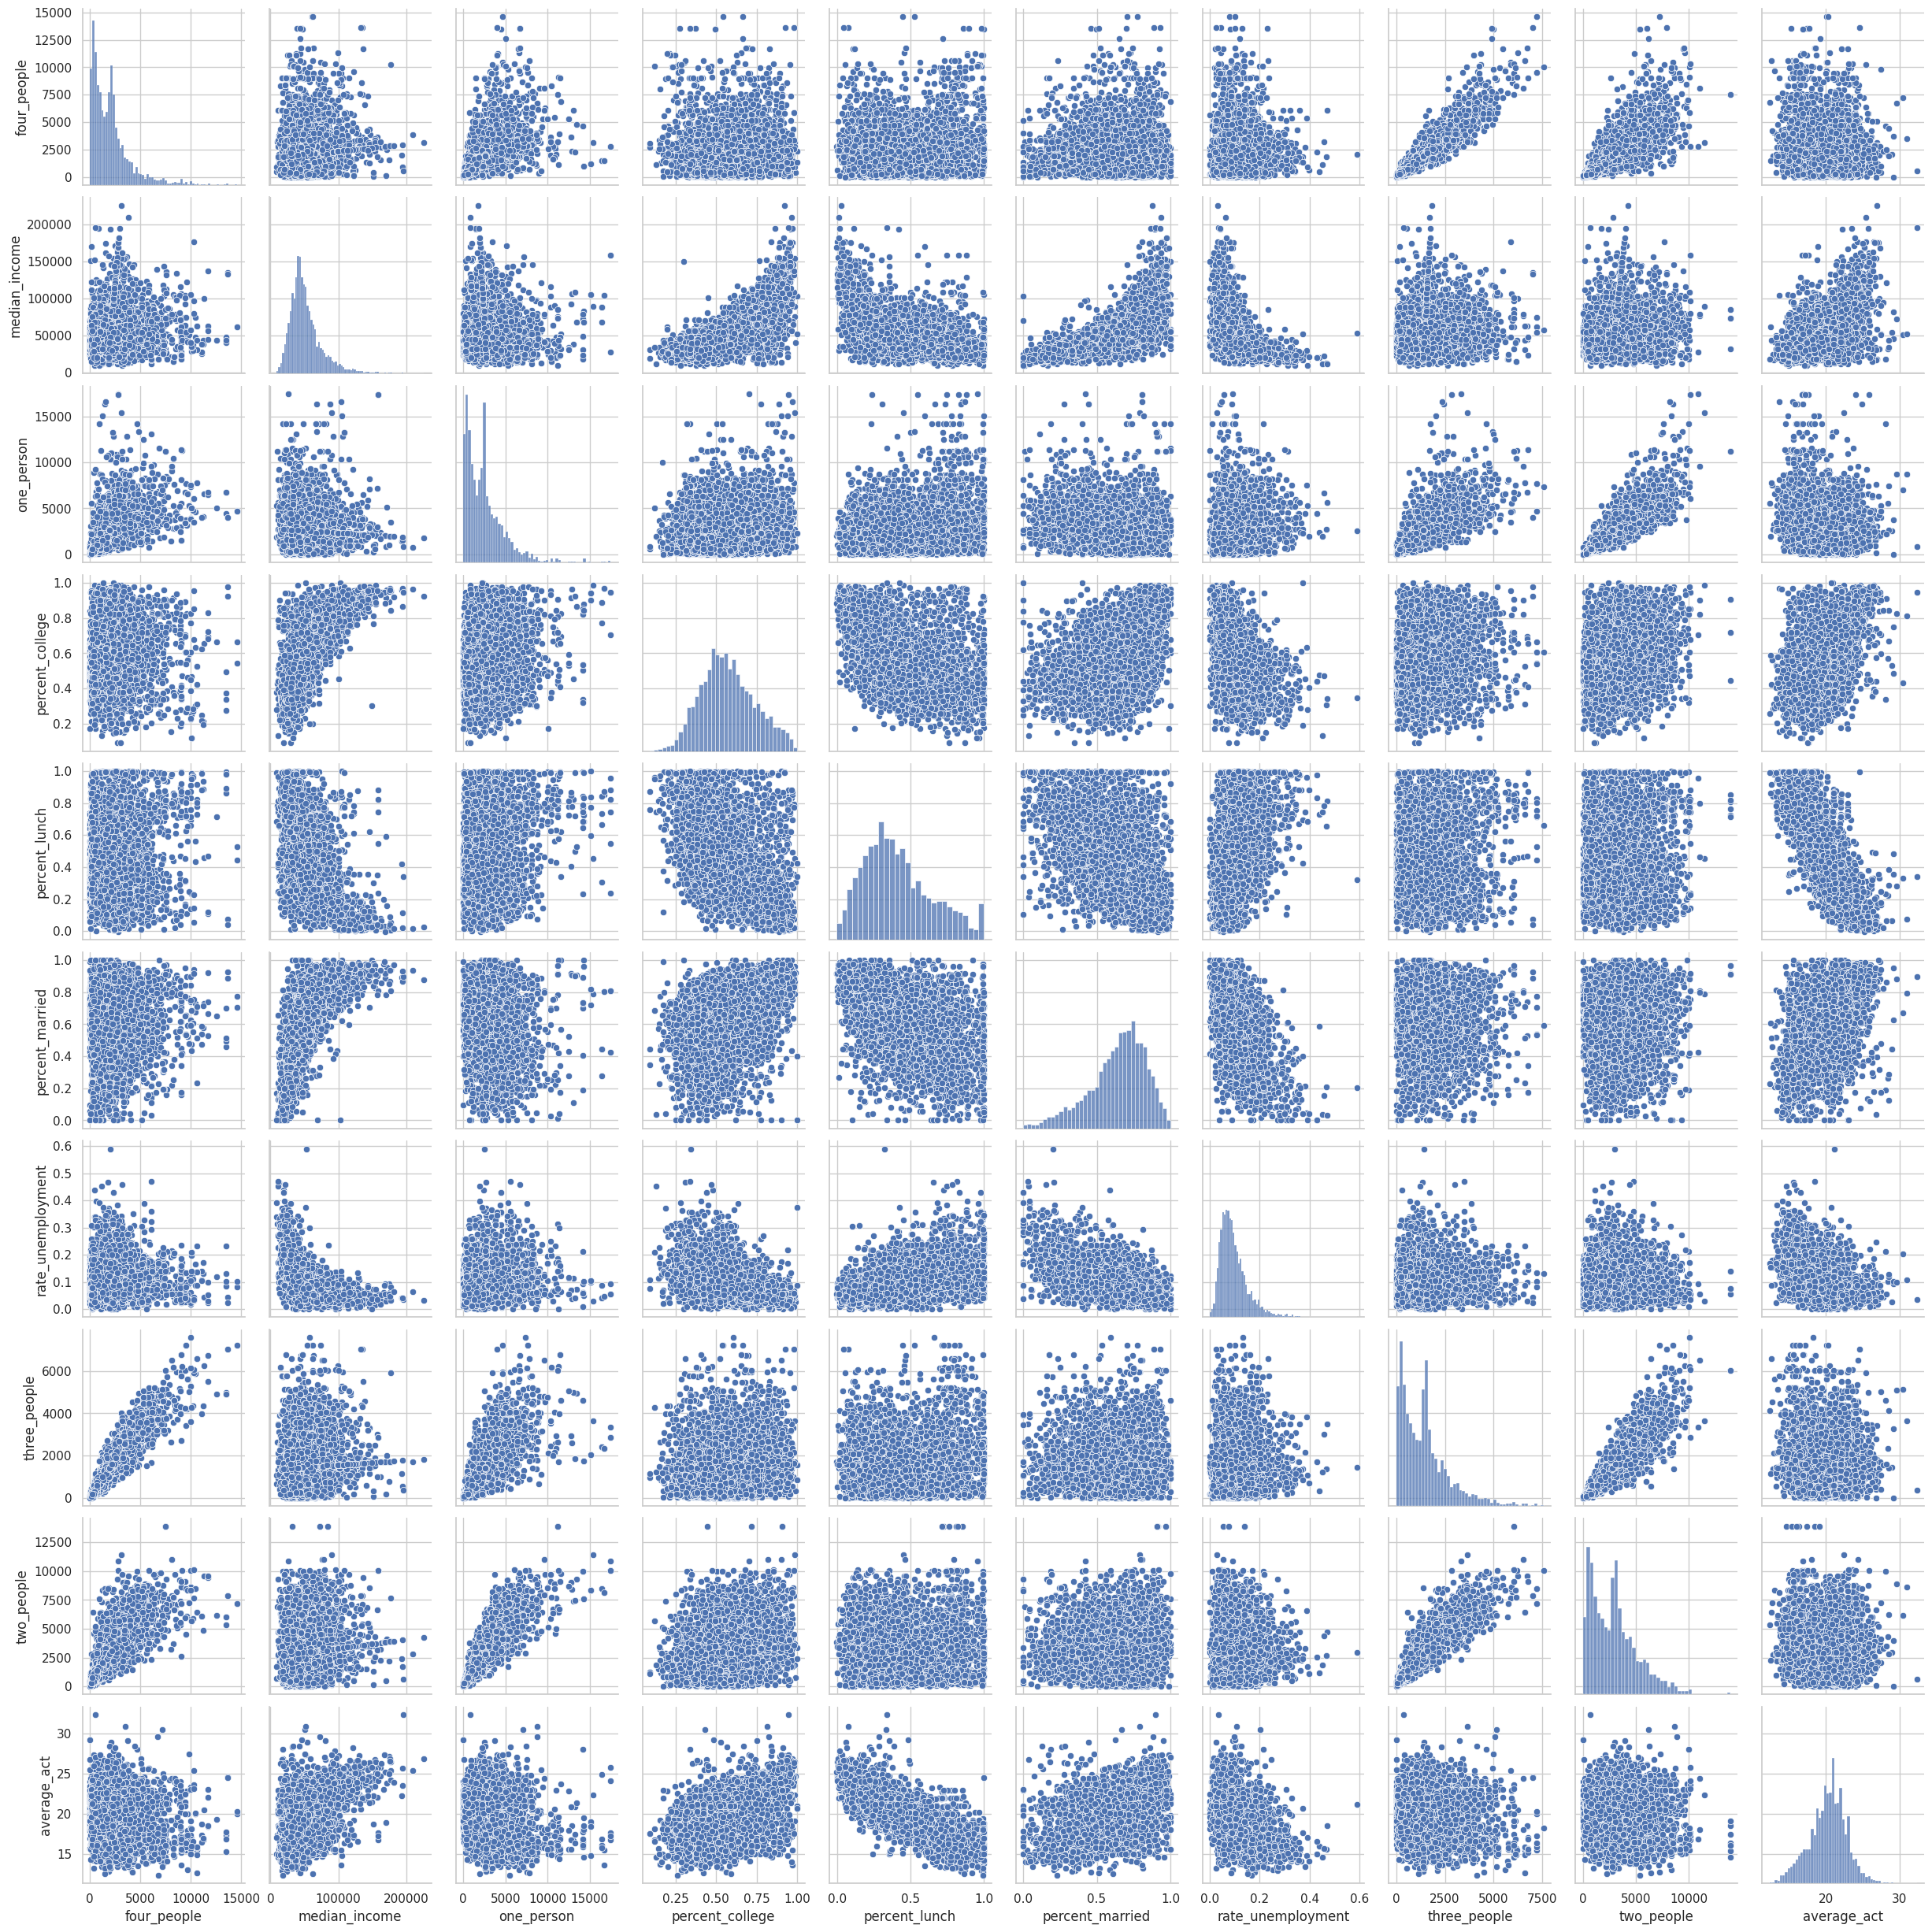

In [ ]:
sns.pairplot(df_train.drop(columns = ['zip_code']))

## Correlation Matrix

create a correlation matrix to see how all of the bariables are correlated

<ipython-input-49-f3c42557993f>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



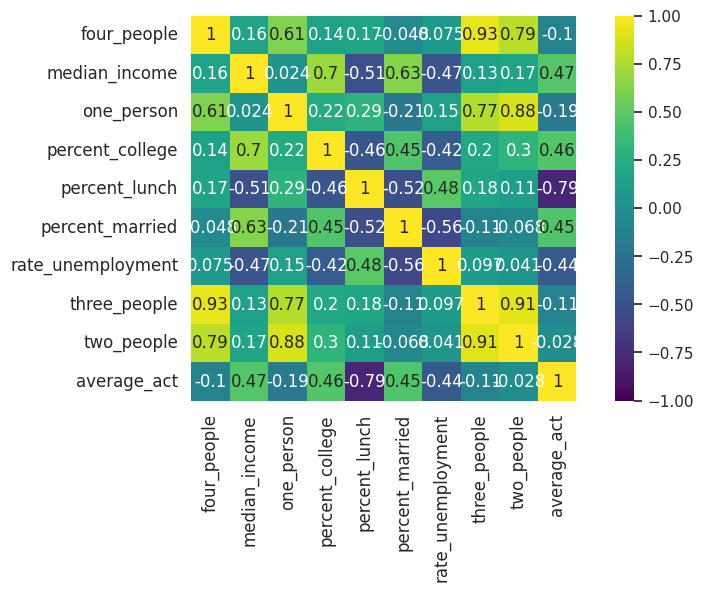

In [ ]:
corr_matrix = df_train.drop(columns = ['zip_code']).corr() 

plt.figure(figsize=(10,5))

sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap='viridis')

plt.tick_params(labelsize=12);

## Model Fits

### create a model fit for all predictors

In [ ]:
model = smf.ols(formula='average_act ~ median_income + rate_unemployment + percent_lunch + percent_married + percent_college + one_person + two_people + three_people + four_people', data = df_train).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     1169.
Date:                Tue, 09 May 2023   Prob (F-statistic):               0.00
Time:                        05:51:18   Log-Likelihood:                -10505.
No. Observations:                5781   AIC:                         2.103e+04
Df Residuals:                    5771   BIC:                         2.110e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.8908      0.15

the p-values for `percent_married` and `median_income` are not relevant or important in this context, with all the variables together. When all 5 variables are together, just `rate_unemployment`, `percent_lunch`, and `percent_college` are really relevant.

Compare each model wiith other models with the same number of variables. Best subset selection code

In [ ]:
X = df_train[df_train.columns.difference(['id', 'average_act', 'year', 'school_type', 'school_level', 'state', 'zip_code'])]

Y = df_train['average_act']

In [ ]:
variable_names = X.columns.values

variable_names

array(['four_people', 'median_income', 'one_person', 'percent_college',
       'percent_lunch', 'percent_married', 'rate_unemployment',
       'three_people', 'two_people'], dtype=object)

Standardize and use the coefficient with the largest magnitude to determine best predictor

In [ ]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

model = LinearRegression()
model.fit(X_std, Y)

coef_abs = np.abs(model.coef_)
best_predictor = X.columns[np.argmax(coef_abs)]
print('The best predictor is:', best_predictor)

The best predictor is: percent_lunch


Initialize best subset selection

In [ ]:
def best_subset_selection(X, Y):

    variable_names = X.columns.values

    number_variables = len(variable_names)

    best_aic = np.zeros(number_variables)
    best_bic = np.zeros(number_variables)
    best_adjusted_rsquared = np.zeros(number_variables)

    best_predictors = list()

    for k in range(number_variables):

        subset_names = list(combinations(variable_names, k+1))

        for n, predictor_names in enumerate(subset_names):

            predictors_subset = X.loc[:, predictor_names]

            model = sm.OLS(Y, sm.add_constant(predictors_subset)).fit() 

            if n == 0:

                best_rsquared_k = model.rsquared
                best_aic_k = model.aic
                best_bic_k = model.bic
                best_adjusted_rsquared_k = model.rsquared_adj
                best_predictors_k = predictor_names

            elif model.rsquared > best_rsquared_k:

                best_rsquared_k = model.rsquared
                best_aic_k = model.aic
                best_bic_k = model.bic
                best_adjusted_rsquared_k = model.rsquared_adj
                best_predictors_k = predictor_names

        best_bic[k] = best_bic_k
        best_aic[k] = best_aic_k
        best_adjusted_rsquared[k] = best_adjusted_rsquared_k
        best_predictors.append(best_predictors_k)

    return best_aic, best_bic, best_adjusted_rsquared, best_predictors

best_subset_selection(X, Y)

(array([21262.37335316, 21100.63403274, 21073.2900734 , 21066.69655722,
        21042.54717494, 21030.43014209, 21028.236253  , 21028.55087149,
        21030.18315347]),
 array([21275.69801708, 21120.62102861, 21099.93940123, 21100.00821701,
        21082.52116668, 21077.06646579, 21081.53490866, 21088.51185911,
        21096.80647304]),
 array([0.63017271, 0.64043841, 0.64219697, 0.6426666 , 0.64421769,
        0.64502397, 0.64521996, 0.64526193, 0.64522302]),
 [('percent_lunch',),
  ('percent_college', 'percent_lunch'),
  ('percent_college', 'percent_lunch', 'rate_unemployment'),
  ('percent_college', 'percent_lunch', 'rate_unemployment', 'two_people'),
  ('percent_college',
   'percent_lunch',
   'rate_unemployment',
   'three_people',
   'two_people'),
  ('four_people',
   'percent_college',
   'percent_lunch',
   'rate_unemployment',
   'three_people',
   'two_people'),
  ('four_people',
   'one_person',
   'percent_college',
   'percent_lunch',
   'rate_unemployment',
   'three_p

Best Model from best AIC: 7 predictors:
 `four_people`, `one_person`, `percent_college`, `percent_lunch`, `rate_unemployment`, `three_people`, `two_people`.

Best Model from best BIC: 6 predictors:
`four_people`, `percent_college`, `percent_lunch`, `rate_unemployment`, `three_people`, `two_people`.

Model with best adjusted r^2: 8 predictors
`four_people`, `one_person`, `percent_college`, `percent_lunch`, `percent_married`, `rate_unemployment`, `three_people`, `two_people`.

Create a plot of the results of the best subset selection to see the best models for AIC, BIC, and Adjusted R^2

In [ ]:
def plot_best_subset_results(best_aic, best_bic, best_adjusted_rsquared, best_predictors):

    number_predictors = np.arange(len(best_aic))+1

    plt.subplots(1,3, figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(number_predictors, best_aic, 'b-o')
    plt.plot(number_predictors[np.argmin(best_aic)], np.min(best_aic), 'ro')
    plt.xticks(number_predictors)
    plt.xlabel('Number of predictors', fontsize=18)
    plt.ylabel('AIC', fontsize=18)
    plt.title(best_predictors[np.argmin(best_aic)])

    plt.subplot(1,3,2)
    plt.plot(number_predictors, best_bic, 'b-o')
    plt.plot(number_predictors[np.argmin(best_bic)], np.min(best_bic), 'ro')
    plt.xticks(number_predictors)
    plt.xlabel('Number of predictors', fontsize=18)
    plt.ylabel('BIC', fontsize=18)
    plt.title(best_predictors[np.argmin(best_bic)])

    plt.subplot(1,3,3)
    plt.plot(number_predictors, best_adjusted_rsquared, 'b-o');
    plt.plot(number_predictors[np.argmax(best_adjusted_rsquared)], np.max(best_adjusted_rsquared), 'ro')
    plt.xticks(number_predictors)
    plt.xlabel('Number of predictors', fontsize=18)
    plt.ylabel('Adjusted R-squared', fontsize=18)
    plt.title(best_predictors[np.argmax(best_adjusted_rsquared)])

    plt.subplots_adjust(wspace = 0.3)

In [ ]:
best_aic, best_bic, best_adjusted_rsquared, best_predictors = best_subset_selection(X, Y)

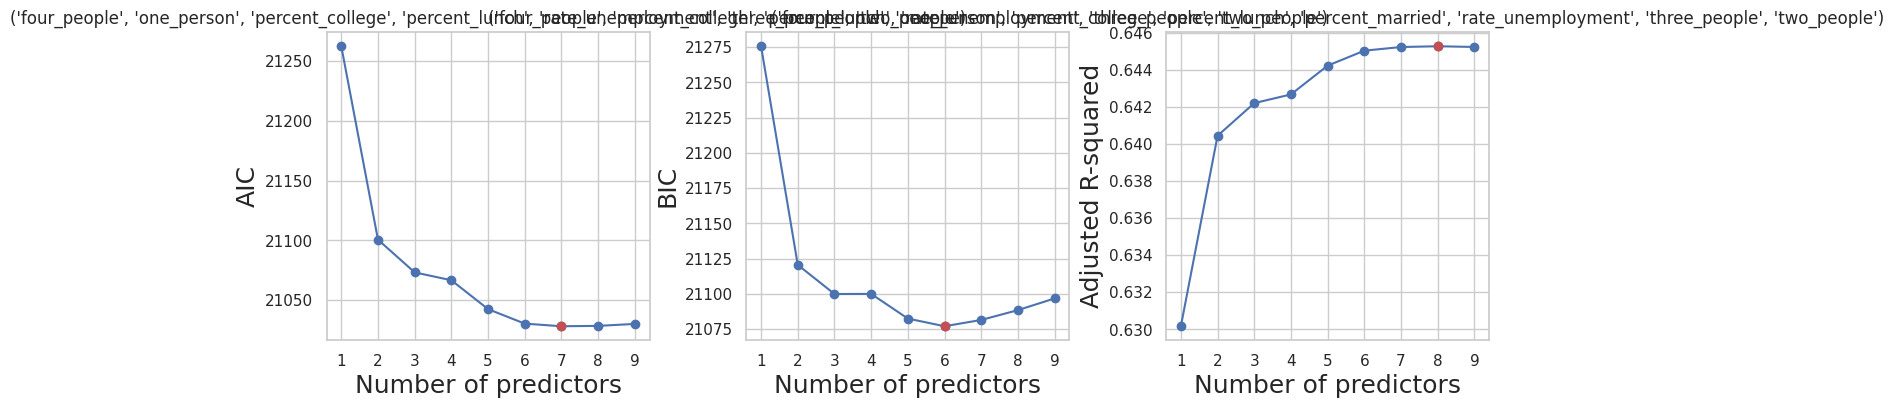

In [ ]:
plot_best_subset_results(best_aic, best_bic, best_adjusted_rsquared, best_predictors)

Now its easier to see the number of predictors that each "best model" has

### Model fit with Regression Line - Median Income and Average ACT Score

Make a scatter plot with a regression line for `median_income` and `average_act`

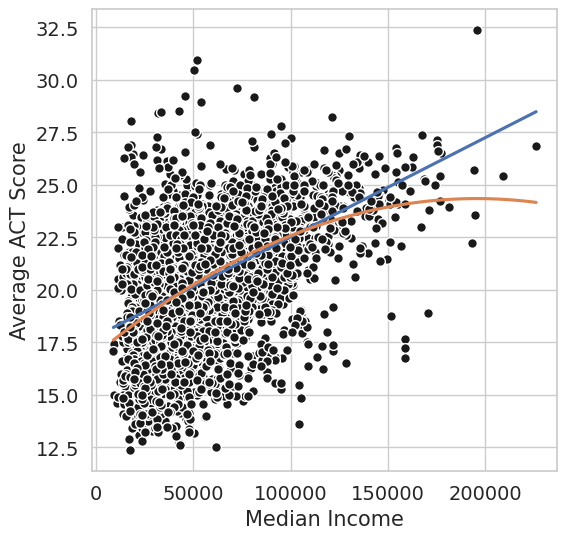

In [ ]:
plt.figure(figsize=(6,6))

# Scatter plot 
plt.plot(df_train['median_income'], df_train['average_act'], 'ko', mec ='w', ms=7)

# Add the regression line
sns.regplot(data=df_train, x = 'median_income', y = 'average_act', order=1, scatter=False, ci=None)
sns.regplot(data=df_train, x = 'median_income', y = 'average_act', order=2, scatter=False, ci=None)

# Add axis labels
plt.xlabel('Median Income', fontsize=15)
plt.ylabel('Average ACT Score', fontsize=15)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14);

Display the fitted model for median income and ACT scores

In [ ]:
median_income_model = smf.ols(formula='average_act ~ median_income', data = df_train).fit()

print(median_income_model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     1596.
Date:                Tue, 09 May 2023   Prob (F-statistic):          2.00e-308
Time:                        05:51:32   Log-Likelihood:                -12800.
No. Observations:                5781   AIC:                         2.560e+04
Df Residuals:                    5779   BIC:                         2.562e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.7846      0.069    258.030

### Model fit with Regression Line - Percent of Students of Assisted Lunch and Average ACT Score

Make a scatter plot with a regression line for `percent_lunch` and `average_act`

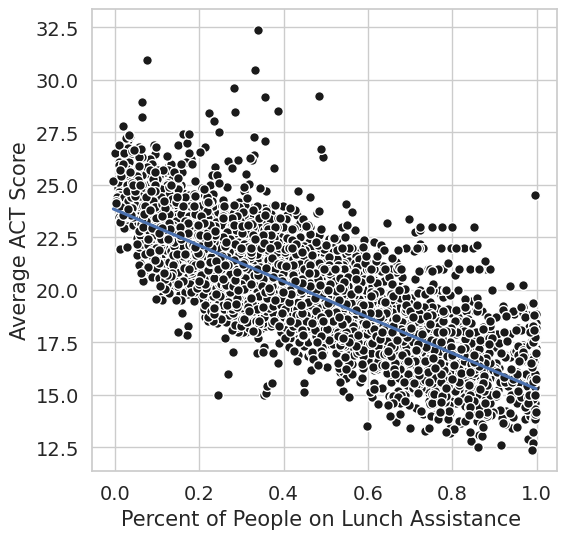

In [ ]:
plt.figure(figsize=(6,6))

# Scatter plot 
plt.plot(df_train['percent_lunch'], df_train['average_act'], 'ko', mec ='w', ms=7)

# Add the regression line
sns.regplot(data=df_train, x = 'percent_lunch', y = 'average_act', order=1, scatter=False, ci=None)

# Add axis labels
plt.xlabel('Percent of People on Lunch Assistance ', fontsize=15)
plt.ylabel('Average ACT Score', fontsize=15)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14);

Thats a very linear regression line

`percent_lunch` model

In [ ]:
percent_lunch_model = smf.ols(formula='average_act ~ percent_lunch', data = df_train).fit()

print(percent_lunch_model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     9850.
Date:                Tue, 09 May 2023   Prob (F-statistic):               0.00
Time:                        05:51:33   Log-Likelihood:                -10629.
No. Observations:                5781   AIC:                         2.126e+04
Df Residuals:                    5779   BIC:                         2.128e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        23.8230      0.041    582.109

## Heat Map Visualizations

Where's the data coming from?

In [ ]:
layout = dict(geo={'scope': 'usa'})

data = dict(type='choropleth',
            locations=df_train['state'].unique(),
            locationmode='USA-states',
            z=np.ones(len(df_train['state'].unique())),
            text=df_train['state'].unique())

x = go.Figure(data=[data], layout=layout)

pyo.iplot(x)

ACT Scores by State

In [ ]:
layout = dict(
    geo={'scope': 'usa'},
    title='ACT Scores by State'
)

#Define Data
data = dict(
    type='choropleth',
    locations=df_train['state'],
    locationmode='USA-states',
    z=df_train['average_act'],
    text=df_train['state'],
    colorscale='Viridis',
    colorbar={'title': 'Average ACT Scores'}
)

#Create figure object
fig = go.Figure(data = [data], layout = layout)

#show the figure
pyo.iplot(fig)

Median Income by State

In [ ]:
layout = dict(
    geo={'scope': 'usa'},
    title='Median Income by State'
)

#Define Data
data = dict(
    type='choropleth',
    locations=df_train['state'],
    locationmode='USA-states',
    z=df_train['median_income'],
    text=df_train['state'],
    colorscale='Viridis',
    colorbar={'title': 'Median Income'}
)

#Create figure object
fig2 = go.Figure(data = [data], layout = layout)

#show the figure
pyo.iplot(fig2)

Percent of Students on Assisted Lunch by State

In [ ]:
layout = dict(
    geo={'scope': 'usa'},
    title='Percent of Students on Assisted Lunch by State'
)

#Define Data
data = dict(
    type='choropleth',
    locations=df_train['state'],
    locationmode='USA-states',
    z=df_train['percent_lunch'],
    text=df_train['state'],
    colorscale='Viridis',
    colorbar={'title': 'Percent of Students on Assisted Lunch'}
)

#Create figure object
fig3 = go.Figure(data = [data], layout = layout)

#show the figure
pyo.iplot(fig3)

`percent_lunch` was the best predictor of ACT scores, and this is the visualization for how those percentages are distributed

## Prediction

set up a model to predict ACT scores

In [ ]:
y_prediction = model.predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LinearRegression was fitted without feature names



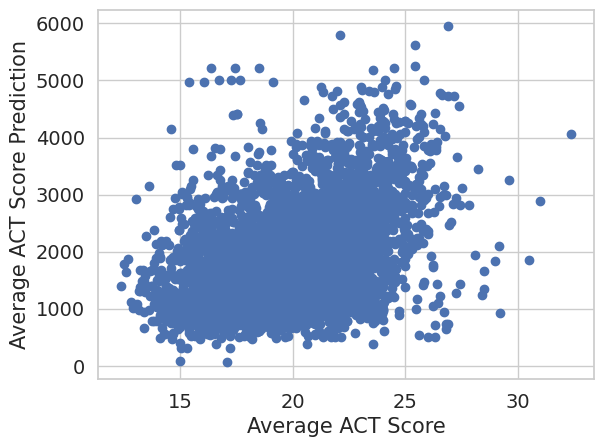

In [ ]:
plt.plot(df_train['average_act'], y_prediction, 'o')

# Add axis labels
plt.xlabel('Average ACT Score', fontsize=15)
plt.ylabel('Average ACT Score Prediction', fontsize=15)

# Increase the fontsize of the tick labels 
plt.tick_params(labelsize=14);

This full model with all predictors is vaguely linear, but it;s not a strong relationship

Create a prediction model using the Adjusted R^2 model with 8 predictors. This model does not include `median_income`

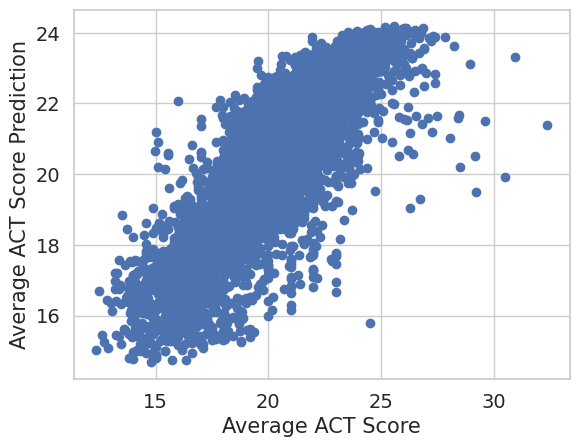

In [ ]:
new_train = X.drop(columns=['median_income'])

# split the predictor and response variables
X2 = new_train
y2 = df_train['average_act']

# fit the linear regression model
model = LinearRegression()
model.fit(X2, y2)

# make predictions using the model
y_pred = model.predict(X2)



plt.plot(df_train['average_act'], y_pred, 'o')

# Add axis labels
plt.xlabel('Average ACT Score', fontsize=15)
plt.ylabel('Average ACT Score Prediction', fontsize=15)

# Increase the fontsize of the tick labels 
plt.tick_params(labelsize=14);

This relationship is much more linear and indicates that we have selected a good model.

# Conclusion

The best model to predict ACT scores is the adjusted R^2 model with 8 predictors, in which `median_income` was excluded.

`median_income` is the least significant predictor.

`percent_lunch` is the best singular predictor of ACT scores.

household size does impact ACT scores, with `two_person` households being the most significant predictor of the various household sizes.